In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import string
import matplotlib.pyplot as plt
from tqdm import tqdm    #import tqdm
from os.path import join
from collections import Counter
import re 
import io
import copy
import psutil
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, LSTM,GRU, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

In [4]:
process = psutil.Process(os.getpid())
print('start', process.memory_info().rss)
cpu_stats()

start 411836416


'memory GB:0.38'

In [5]:
pip install editdistance

     |████████████████████████████████| 179 kB 1.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import editdistance

In [7]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

TensorFlow version: 2.3.1
Keras version: 2.4.3


In [8]:
ls -la /kaggle/input/aij-digital-peter/

total 12
drwxr-xr-x 3 nobody nogroup 4096 Nov  1 21:30 ./
drwxr-xr-x 3 root   root    4096 Nov 11 11:45 ../
drwxr-xr-x 4 nobody nogroup 4096 Nov  1 21:31 train/


In [9]:
data_path = "/kaggle/input/aij-digital-peter/"

In [10]:
vert_sample = "/kaggle/input/aij-digital-peter/train/images/2_13_14.jpg"

In [11]:
ls -la /kaggle/input/aij-digital-peter/train/images/2_13_14.jpg

-rw-r--r-- 1 nobody nogroup 69288 Nov  1 21:31 /kaggle/input/aij-digital-peter/train/images/2_13_14.jpg


In [12]:
#В этой папке лежат txt файлы перевода
trans_dir = data_path + 'train/words'
#В этой папке лежат  jpg файлы изображений
image_dir = data_path + 'train/images'

print(len(os.listdir(trans_dir)))

6196


Посмотрим на отдельное изображение.

In [13]:
example = os.listdir(image_dir)[100]
example

'467_9_14.jpg'

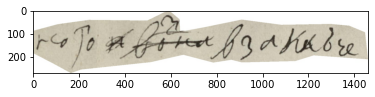

In [14]:
img = plt.imread(image_dir+'/'+example)
plt.imshow(img)
plt.show()

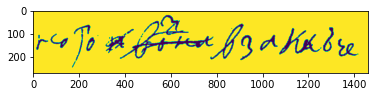

In [15]:
originalImage = cv2.imread(image_dir+'/'+example)
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
  
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 150, 255, cv2.THRESH_BINARY)
 
plt.imshow(blackAndWhiteImage)
  
# cv2.waitKey(0)
# cv2.destroyAllWindows()

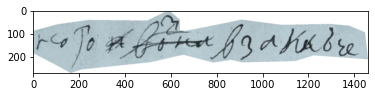

In [16]:
plt.imshow(originalImage)

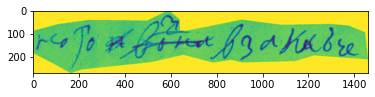

In [17]:
plt.imshow(grayImage)

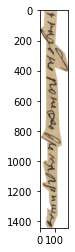

In [18]:
img = plt.imread(vert_sample)
plt.imshow(img)
plt.show()

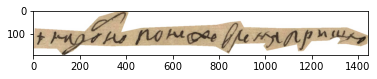

In [19]:
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)   # ROTATE_90_CLOCKWISE
plt.imshow(img)
plt.show()

И его перевод.

In [20]:
with io.open(trans_dir+'/'+example[:-3]+'txt', 'r',  encoding='utf8') as file:
    data = file.read()

print(data)

ного и возна в заключе


В текстах встречаются слова, содержащие английские символы.

Но так как английских символов в целом не очень много, то из train-выборки можно удалить строки с ними (и обучаться только на оставшихся строках). Так мы и сделаем в текущем бейзлайне. Это сократит алфавит (и, как следствие, избавит нас от лишней шумности). 

При этом надо понимать, что в тестовой выборке английские символы, скорее всего, будут присутствовать. Поэтому будут и вынужденные ошибки, связанные с нашей вольной фильтрацией обучающей выборки.

Впрочем, метод распознавания всегда выбираете вы сами. 

Кроме того, советуем внимательно изучить train-выборку глазами.

In [21]:
english = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'm', 'n' ,'o', 'p', 'r', 's', 't', 'u', 'w']

In [22]:
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

Следующая функция подготавливает лэйблы, то есть переведенный текст. Как уже было сказано, игнорируются примеры, содержащие английские буквы.

In [23]:
def process_texts(image_dir,trans_dir):
    lens = []
    include_english = 0
    letters = ''

    lines = []
    names = []
    
    all_files = os.listdir(trans_dir)
    for filename in os.listdir(image_dir):
        if filename[:-3]+'txt' in all_files:
            name, ext = os.path.splitext(filename)
            txt_filepath = join(trans_dir, name + '.txt')
            with open(txt_filepath, 'r') as file:
                data = file.read()
                if len(data)==0:
                    continue
                if len(set(data).intersection(english))>0:
                    continue

                lines.append(data)
                names.append(filename)
                lens.append(len(data))
                letters += data
    print('Максимальная длина строки:', max(Counter(lens).keys()))
    print('Количество строк с английскими буквами ',include_english)

    return names,lines,Counter(letters)

В итоге мы получаем список изображений, соответствующий ему обработанный список строк и словарь символов.

In [24]:
names,lines,cnt = process_texts(image_dir,trans_dir)

Максимальная длина строки: 71
Количество строк с английскими буквами  0


In [25]:
letters = set(cnt.keys())

letters = sorted(list(letters))
print('Символы train:', ' '.join(letters))

Символы train:   ) + / 0 1 2 3 4 5 6 7 8 9 [ ] i k l | × ǂ а б в г д е ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я і ѣ – … ⊕ ⊗


Следующая функция подгружает изображения, меняет их до необходимого размера и нормирует.

In [26]:
def process_image(img):
    w, h,_ = img.shape
    
    new_w = 128
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h,_ = img.shape
    
    img = img.astype('float32')
    
    if w < 128:
        add_zeros = np.full((128-w, h,3), 255)
        img = np.concatenate((img, add_zeros))
        w, h,_ = img.shape
    
    if h < 1024:
        add_zeros = np.full((w, 1024-h,3), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h,_ = img.shape
        
    if h > 1024 or w > 128:
        dim = (1024,128)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)

    img = img / 255
    
    return img

In [27]:
def process_image_g(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape
#     print(f"w: {w} h: {h}")
    if h > (w*2.5):
        img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)   # ROTATE_90_CLOCKWISE
        h, w = img.shape
    
    new_h = 128
    new_w = int(w * (new_h / h))
    img = cv2.resize(img, (new_w, new_h))
    h, w = img.shape
    
    img = img.astype('float32')
    
    if h < 128:
        add_zeros = np.full((128-h, w), 255)
        img = np.concatenate((img, add_zeros))
        h, w = img.shape
    
    if w < 1024:
        add_zeros = np.full((h, 1024-w), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        h, w = img.shape
        
    if w > 1024 or h > 128:
        dim = (1024,128)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)

    img = img / 255
    
    return img

w: 1256 h: 355


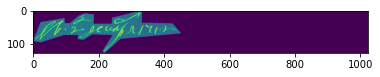

In [28]:
vert_sample_2 = "/kaggle/input/aij-digital-peter/train/images/2_13_13.jpg"
img_vs = plt.imread(vert_sample_2)
img_vs = cv2.cvtColor(img_vs, cv2.COLOR_BGR2GRAY)
h, w = img_vs.shape
print(f"w: {w} h: {h}")
img_vs = process_image_g(plt.imread(vert_sample_2))
plt.imshow(img_vs)
plt.show()

w: 191 h: 1444


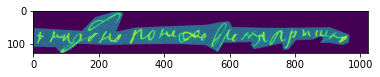

In [29]:
img_vs = plt.imread(vert_sample)
img_vs = cv2.cvtColor(img_vs, cv2.COLOR_BGR2GRAY)
h, w = img_vs.shape
print(f"w: {w} h: {h}")
img_vs = process_image_g(plt.imread(vert_sample))
plt.imshow(img_vs)
plt.show()

**Подготовим обучающие и валидационные данные.**

In [30]:
def generate_data(lines,names,image_dir):
    data_images = []
    data_labels = []
    data_input_length = []
    data_label_length = []
    data_original_text = []
    data_original_image = []
    
    max_label_len = 0
    for line, name in tqdm(zip(lines,names)):    # for line, name in tqdm.tqdm_notebook(zip(lines,names)):
        img = cv2.imread(image_dir+'/'+name)
        # original_image = copy.deepcopy(img)
        img = process_image_g(img)    # img = process_image(img)
        try:
            label = text_to_labels(line)
        except:
            print('bad_label')
            continue
        data_images.append(img)
        data_labels.append(label)
        data_input_length.append(255)
        data_label_length.append(len(line))
        data_original_text.append(line)
        # data_original_image.append(original_image)
        
        if len(line) > max_label_len:
            max_label_len = len(line)
        
    return data_images, data_labels, data_input_length, data_label_length, \
            data_original_text, data_original_image, max_label_len

Создадим обучающую и валидационную выборки.

In [31]:
lines_train = []
names_train = []

lines_val = []
names_val = []


for num,(line, name) in enumerate(zip(lines,names)):
    if num % 15 == 0:
        lines_val.append(line)
        names_val.append(name)
    else:
        lines_train.append(line)
        names_train.append(name)

In [32]:
process = psutil.Process(os.getpid())
print('start', process.memory_info().rss)
cpu_stats()

start 441102336


'memory GB:0.41'

In [33]:
train_images, train_labels, train_input_length, train_label_length, train_original_text, train_original_image, \
        train_max_label_len = generate_data(lines_train, names_train, image_dir)

5698it [01:14, 76.11it/s]


In [34]:
process = psutil.Process(os.getpid())
print('start', process.memory_info().rss)
cpu_stats()

start 5711032320


'memory GB:5.32'

In [35]:
# import pickle

In [36]:
# with open('train_images.pickle', 'wb') as fl:
#     pickle.dump(train_images, fl)

In [37]:
val_images, val_labels, val_input_length, val_label_length, val_original_text, val_original_image, \
        val_max_label_len = generate_data(lines_val, names_val, image_dir)

407it [00:06, 66.30it/s]


In [38]:
process = psutil.Process(os.getpid())
print('start', process.memory_info().rss)
cpu_stats()

start 6092087296


'memory GB:5.67'

In [39]:
# with open('val_images.pickle', 'wb') as fl:
#     pickle.dump(val_images, fl)

In [40]:
# ls -la

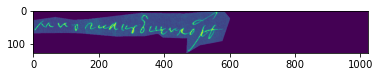

In [41]:
plt.imshow(val_images[0])
plt.show()

In [42]:
max_label_len = max(train_max_label_len,val_max_label_len)
print(max_label_len)

71


Выведем пару обработанных изображений с переводом.

к чему въ первых надлежит


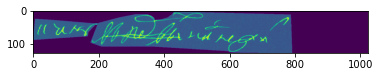

без тягости народа за чем горазда смот


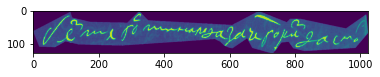

In [43]:
rnd = np.random.choice(range(len(train_images)),2)

for i in rnd:
    print(train_original_text[i])
    plt.imshow(train_images[i])
    plt.show()

**Дополним строки до максимальной длины**

In [44]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(letters))

val_padded_label = pad_sequences(val_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(letters))

In [45]:
train_padded_label.shape, val_padded_label.shape

((5698, 71), (407, 71))

In [46]:
process = psutil.Process(os.getpid())
print('start', process.memory_info().rss)
cpu_stats()

start 6093471744


'memory GB:5.67'

In [47]:
train_images = np.asarray(train_images, dtype='float32')
train_input_length = np.asarray(train_input_length, dtype='int16')
train_label_length = np.asarray(train_label_length, dtype='int16')

val_images = np.asarray(val_images, dtype='float32')
val_input_length = np.asarray(val_input_length, dtype='int16')
val_label_length = np.asarray(val_label_length, dtype='int16')

In [48]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
val_images = val_images.reshape(val_images.shape[0], val_images.shape[1], val_images.shape[2], 1)

In [49]:
process = psutil.Process(os.getpid())
print('start', process.memory_info().rss)
cpu_stats()

start 9294270464


'memory GB:8.66'

In [50]:
train_images.shape

(5698, 128, 1024, 1)

## **Строим модель**

Модель состоит из нескольких слоев CNN, GRU и использует ctc_loss. [Вот](https://www.youtube.com/watch?v=SAfJ6nP2rrI) хорошее видео о нем на русском.

In [51]:
inputs = Input(shape=(128,1024,1))

conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(4, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(4, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

pool_4 = MaxPool2D(pool_size=(4, 1),padding='same')(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(4, 1),padding='same')(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

blstm_1 = Bidirectional(LSTM(1024, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(1024, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(letters)+1, activation = 'softmax')(blstm_2)
act_model = Model(inputs=inputs, outputs=outputs)
    
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int16')   # input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int16')   # label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [52]:
act_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 1024, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 1024, 64)     640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 512, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 512, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 256, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 256, 256)      295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 256, 256)     

In [53]:
batch_size = 20
epochs = 300

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics=['accuracy'])

os.makedirs('checkpoint', exist_ok=True)

filepath="checkpoint/model_lstm_1024_20.hdf5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=5, min_lr=0.00001)

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint,es,reduce_lr]

history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([val_images, val_padded_label, val_input_length, val_label_length], [np.zeros(len(val_images))]),
                    verbose=2,
                    callbacks=callbacks_list)


Epoch 1/300

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to checkpoint/model_lstm_1024_20.hdf5
285/285 - 184s - loss: 109.8409 - accuracy: 0.0000e+00 - val_loss: 99.5882 - val_accuracy: 0.0000e+00
Epoch 2/300

Epoch 00002: val_accuracy did not improve from 0.00000
285/285 - 178s - loss: 88.5868 - accuracy: 0.0000e+00 - val_loss: 89.6458 - val_accuracy: 0.0000e+00
Epoch 3/300

Epoch 00003: val_accuracy did not improve from 0.00000
285/285 - 178s - loss: 78.6809 - accuracy: 0.0000e+00 - val_loss: 228.7275 - val_accuracy: 0.0000e+00
Epoch 4/300

Epoch 00004: val_accuracy did not improve from 0.00000
285/285 - 178s - loss: 35.0015 - accuracy: 0.0000e+00 - val_loss: 30.4673 - val_accuracy: 0.0000e+00
Epoch 5/300

Epoch 00005: val_accuracy improved from 0.00000 to 0.01720, saving model to checkpoint/model_lstm_1024_20.hdf5
285/285 - 179s - loss: 16.6529 - accuracy: 0.0060 - val_loss: 14.6550 - val_accuracy: 0.0172
Epoch 6/300

Epoch 00006: val_accuracy improved from

__LSTM 256 R:__

Epoch 00030: val_accuracy improved from 0.22359 to 0.22604, saving model to checkpoint/model_lstm_256.hdf5
285/285 - 90s - loss: 0.1888 - accuracy: 0.9221 - val_loss: 12.2445 - val_accuracy: 0.2260
Epoch 31/300

Epoch 00031: val_accuracy improved from 0.22604 to 0.23342, saving model to checkpoint/model_lstm_256.hdf5
285/285 - 90s - loss: 0.2058 - accuracy: 0.9156 - val_loss: 12.6246 - val_accuracy: 0.2334
Epoch 00031: early stopping

GRU 384: 

Epoch 00031: val_accuracy improved from 0.22604 to 0.23342, saving model to checkpoint/model_gru.hdf5
285/285 - 96s - loss: 1.4023 - accuracy: 0.8642 - val_loss: 11.1329 - val_accuracy: 0.2334
Epoch 00031: early stopping

LSTM 384: 

Epoch 00031: val_accuracy did not improve from 0.21867
285/285 - 100s - loss: 1.0820 - accuracy: 0.9240 - val_loss: 14.4068 - val_accuracy: 0.2162
Epoch 00031: early stopping

LSTM 384 R: 

Epoch 00036: val_accuracy did not improve from 0.24816
285/285 - 100s - loss: 0.1289 - accuracy: 0.9507 - val_loss: 11.0478 - val_accuracy: 0.2408
Epoch 00036: early stopping

GRU 512 R: 

Epoch 00031: val_accuracy did not improve from 0.23342
285/285 - 103s - loss: 0.2373 - accuracy: 0.9094 - val_loss: 10.6688 - val_accuracy: 0.2334
Epoch 00031: early stopping

LSTM 512 R: 

Epoch 00029: val_accuracy did not improve from 0.23833
285/285 - 118s - loss: 0.1149 - accuracy: 0.9602 - val_loss: 10.4089 - val_accuracy: 0.2383
Epoch 30/300

Epoch 00030: val_accuracy did not improve from 0.23833
285/285 - 118s - loss: 0.2184 - accuracy: 0.9075 - val_loss: 10.8032 - val_accuracy: 0.1941
Epoch 00030: early stopping

LSTM 512 R 64: 

Epoch 00038: val_accuracy did not improve from 0.18673
90/90 - 78s - loss: 0.1537 - accuracy: 0.9531 - val_loss: 11.5777 - val_accuracy: 0.1794
Epoch 00038: early stopping

LSTM 768 R: 

Epoch 00028: val_accuracy improved from 0.25061 to 0.26290, saving model to checkpoint/model_lstm_768.hdf5
285/285 - 140s - loss: 0.1177 - accuracy: 0.9570 - val_loss: 11.3175 - val_accuracy: 0.2629
Epoch 29/300

Epoch 00029: val_accuracy did not improve from 0.26290
285/285 - 140s - loss: 0.0994 - accuracy: 0.9684 - val_loss: 11.7199 - val_accuracy: 0.2432
Epoch 30/300

Epoch 00030: val_accuracy did not improve from 0.26290
285/285 - 140s - loss: 0.1107 - accuracy: 0.9617 - val_loss: 12.0675 - val_accuracy: 0.2482
Epoch 31/300

Epoch 00031: val_accuracy did not improve from 0.26290
285/285 - 140s - loss: 0.1352 - accuracy: 0.9488 - val_loss: 12.1216 - val_accuracy: 0.2457
Epoch 00031: early stopping

LSTM 1024 R: 

Epoch 00036: val_accuracy improved from 0.26781 to 0.28010, saving model to checkpoint/model_lstm_1024.hdf5
285/285 - 177s - loss: 0.0433 - accuracy: 0.9875 - val_loss: 10.8352 - val_accuracy: 0.2801
Epoch 37/300

Epoch 00037: val_accuracy did not improve from 0.28010
285/285 - 176s - loss: 0.0332 - accuracy: 0.9942 - val_loss: 10.9423 - val_accuracy: 0.2678
Epoch 38/300

Epoch 00038: val_accuracy did not improve from 0.28010
285/285 - 176s - loss: 0.0448 - accuracy: 0.9874 - val_loss: 11.0578 - val_accuracy: 0.2629
Epoch 39/300

Epoch 00039: val_accuracy did not improve from 0.28010
285/285 - 176s - loss: 0.0426 - accuracy: 0.9893 - val_loss: 11.1605 - val_accuracy: 0.2383
Epoch 00039: early stopping

LSTN 1024 R 10: 

Epoch 00028: val_accuracy improved from 0.25061 to 0.26536, saving model to checkpoint/model_lstm_1024_10.hdf5
570/570 - 226s - loss: 0.2756 - accuracy: 0.8738 - val_loss: 10.8429 - val_accuracy: 0.2654
Epoch 29/300

Epoch 00029: val_accuracy did not improve from 0.26536
570/570 - 225s - loss: 0.2198 - accuracy: 0.9021 - val_loss: 11.0677 - val_accuracy: 0.2654
Epoch 30/300

Epoch 00030: val_accuracy did not improve from 0.26536
570/570 - 226s - loss: 0.2061 - accuracy: 0.9098 - val_loss: 11.3000 - val_accuracy: 0.2408
Epoch 31/300

Epoch 00031: val_accuracy did not improve from 0.26536
570/570 - 226s - loss: 0.1802 - accuracy: 0.9210 - val_loss: 11.4935 - val_accuracy: 0.2580
Epoch 32/300

Epoch 00032: val_accuracy improved from 0.26536 to 0.27764, saving model to checkpoint/model_lstm_1024_10.hdf5
570/570 - 227s - loss: 0.1871 - accuracy: 0.9147 - val_loss: 11.7252 - val_accuracy: 0.2776
Epoch 00032: early stopping

LSTM 1024 R 40: 

Epoch 00036: val_accuracy improved from 0.26290 to 0.26536, saving model to checkpoint/model_lstm_1024_40.hdf5
143/143 - 140s - loss: 0.0258 - accuracy: 0.9967 - val_loss: 11.9028 - val_accuracy: 0.2654
Epoch 37/300

Epoch 00037: val_accuracy did not improve from 0.26536
143/143 - 138s - loss: 0.0218 - accuracy: 0.9979 - val_loss: 11.8603 - val_accuracy: 0.2506
Epoch 38/300

Epoch 00038: val_accuracy did not improve from 0.26536
143/143 - 138s - loss: 0.0179 - accuracy: 0.9988 - val_loss: 11.9197 - val_accuracy: 0.2604
Epoch 39/300

Epoch 00039: val_accuracy did not improve from 0.26536
143/143 - 138s - loss: 0.0168 - accuracy: 0.9988 - val_loss: 11.9836 - val_accuracy: 0.2629
Epoch 00039: early stopping


LSTM 1024 R 20: 

Epoch 00032: val_accuracy improved from 0.28010 to 0.28501, saving model to checkpoint/model_lstm_1024_20.hdf5
285/285 - 179s - loss: 0.0981 - accuracy: 0.9658 - val_loss: 11.8005 - val_accuracy: 0.2850
Epoch 33/300

Epoch 00033: val_accuracy did not improve from 0.28501
285/285 - 177s - loss: 0.1213 - accuracy: 0.9605 - val_loss: 13.4844 - val_accuracy: 0.2506
Epoch 34/300

Epoch 00034: val_accuracy did not improve from 0.28501
285/285 - 178s - loss: 0.1504 - accuracy: 0.9403 - val_loss: 11.9105 - val_accuracy: 0.2826
Epoch 00034: early stopping

Посмотрим качество на валидации.

In [54]:
import time

In [55]:
start = time.time()
act_model.load_weights(filepath)
prediction = act_model.predict(val_images)

decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)
end = time.time()
print(end-start)

6.619359016418457


LSTM 256 R: 4.716141700744629

LSTM 384: 5.0529961585998535

LSTM 384 R: 4.932627439498901

GRU 512 R: 4.939647436141968

LSTM 512 R: 5.386308431625366

LSTM 512 R 64: 4.418805360794067

LSTM 768 R: 5.505225658416748

LSTM 1024 R: 6.45198130607605

LSTM 1024 R 10: 6.250160455703735

LSTM 1024 R 40: 6.376370429992676

LSTM 1024 R 20: 6.619359016418457

In [56]:
numCharErr = 0
numCharTotal = 0
numStringOK = 0
numStringTotal = 0

word_eds, word_true_lens = [], []

print('Ground truth -> Recognized')	
for i in range(len(out)):
    pred = ''
    for p in out[i]:
        if int(p) != -1:
            pred+=letters[int(p)]
    true = val_original_text[i]
    
    numStringOK += 1 if true == pred else 0
    numStringTotal += 1
    dist = editdistance.eval(pred, true)
    numCharErr += dist
    numCharTotal += len(true)
    
    pred_words = pred.split()
    true_words = true.split()
    word_eds.append(editdistance.eval(pred_words, true_words))
    word_true_lens.append(len(true_words))
    
    print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + true + '"', '->', '"' + pred + '"')

charErrorRate = numCharErr / numCharTotal
wordErrorRate = sum(word_eds) / sum(word_true_lens) 
stringAccuracy = numStringOK / numStringTotal
print('Character error rate: %f%%. Word error rate: %f%%. String accuracy: %f%%.' % \
      (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0))

Ground truth -> Recognized
[OK] "ми отакующия обрѣ" -> "ми отакующия обрѣ"
[OK] "1" -> "1"
[ERR:2] "аднакож надлесжит тому хто оспорит тое про" -> "аднакож надленжит тому хто оспорит тоепро"
[ERR:3] "реблял а пъротчие б пошли" -> "реблял апъритче б пошли"
[ERR:2] "но такъ i дѣлаем поклон отдай теткѣ от меня" -> "но такъ i дѣлаем послон отдайтеткѣ от меня"
[ERR:1] "к оной рекѣ" -> "коной рекѣ"
[OK] "ликую" -> "ликую"
[OK] "для болных лекарства" -> "для болных лекарства"
[ERR:5] "не худо толко не знаю захочет ли датской тово рати" -> "неху до толко не знаю за хочетли датской тово рата"
[ERR:2] "величеству i ритчи" -> "величеству iрит и"
[OK] "маршу зело томны а когда придут к го" -> "маршу зело томны а когда придут к го"
[ERR:8] "тъмаршалу а оному лѣвым" -> "тъ марш алу томулѣ вым"
[OK] "но i запасы целы також i iх починит мочно" -> "но i запасы целы також i iх починит мочно"
[ERR:1] "тербурхъ" -> "тер бурхъ"
[ERR:2] "пока подлинную вѣдомость по" -> "пока подлинную вѣдомосто го"
[ERR:7] 

[ERR:3] "въпротчем все полагаю на ваше разсуждение" -> "въ протчем все полагаюла ваше разсуждение"
[OK] "+" -> "+"
[ERR:5] "скота i другова чего iз полши возмет с собою" -> "с кота i другова чего iз полши возмот кобою"
[ERR:2] "ки толкуя сей пунктъ iна" -> "ски толкуя сей пунктъ i на"
[ERR:3] "окъромѣ кудрявъцова" -> "окъромѣгз кудрявъцава"
[ERR:1] "цовом вице адмирал обявил что полу" -> "цо вом вице адмирал обявил что полу"
[ERR:1] "з датскими дѣлат" -> "здатскими дѣлат"
[OK] "к штетину iбо несытыя салдаты" -> "к штетину iбо несытыя салдаты"
[OK] "надлежит писат бутто б для оберега" -> "надлежит писат бутто б для оберега"
[OK] "далее" -> "далее"
[OK] "примаетца" -> "примаетца"
[ERR:1] "один ступинской которой починен управълят i гер" -> "один ступинской которой починен управѣлят i гер"
[ERR:1] "всѣм ожидат ежели на сие не соiзволит" -> "всѣ ожидат ежели на сие не соiзволит"
[OK] "при сем" -> "при сем"
[ERR:2] "при обѣiх случаях ничево опасатца надлежит" -> "при обѣiх случаях ничево оп

GRU 256: Character error rate: 9.502422%. Word error rate: 41.184637%. String accuracy: 24.078624%.

LSTM 256 R: Character error rate: 7.601966%. Word error rate: 40.105163%. String accuracy: 27.764128%.

GRU 384: Character error rate: 7.710172%. Word error rate: 38.246817%. String accuracy: 28.501229%.

LSTM 384: Character error rate: 9.379128%. Word error rate: 39.194817%. String accuracy: 27.027027%.

LSTM 384 R: Character error rate: 6.605020%. Word error rate: 36.094401%. String accuracy: 28.992629%.

GRU 512 R: Character error rate: 6.754734%. Word error rate: 35.585377%. String accuracy: 29.238329%.

LSTM 512 R: Character error rate: 6.428240%. Word error rate: 35.210578%. String accuracy: 28.992629%.

LSTM 512 R 64: Character error rate: 8.026010%. Word error rate: 42.115573%. String accuracy: 22.358722%.

LSTM 768 R: Character error rate: 6.382010%. Word error rate: 33.652008%. String accuracy: 30.712531%.

LSTM 1024 R: Character error rate: 6.372503%. Word error rate: 33.496572%. String accuracy: 30.958231%.

LSTM 1024 R 10: Character error rate: 6.636926%. Word error rate: 34.751434%. String accuracy: 33.906634%.

LSTM 1024 R 40: Character error rate: 6.882890%. Word error rate: 36.076555%. String accuracy: 29.484029%.

LSTM 1024 R 20: Character error rate: 6.454843%. Word error rate: 34.703633%. String accuracy: 33.415233%.

**Загружаем тестовые изображения, делаем предсказания и записываем их в файл.**

Этот ноутбук - публичный бейзлайн. Тестовая выборка будет автоматически подкладываться в образ, куда участник загрузит модель. Поэтому сейчас следующие строчки закомменчены. И пример запуска модели и записи предсказаний в файл будет проведен на валидационных изображениях.

In [57]:
#Для примера работы запуска модели и записи в файл, пусть валидация станет тестовыми изображениями
test_images = val_images
names_test = names_val

In [58]:
#test_image_dir = 'test/images'

In [59]:
# test_images = []
# names_test = []

# for name in  os.listdir(test_image_dir):
#     img = cv2.imread(test_image_dir+'/'+name)
#     img = process_image(img)
#     test_images.append(img)
#     names_test.append(name)
# test_images = np.asarray(test_images)

In [60]:
start = time.time()

prediction =act_model.predict(test_images)
 
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

prediction = []
for i, x in enumerate(out):
    pred = ''
    for p in x:
        if int(p) != -1:
            pred+=letters[int(p)]
            
    prediction.append(pred)
end = time.time()
print(end - start)

3.10937762260437


LSTM 256 R: 1.8709514141082764

GRU 384: 1.6304709911346436

GRU 384: 1.8490509986877441

LSTM 384: 1.880892038345337

LSTM 384 R: 1.93514084815979

GRU 512 R: 2.5451066493988037

LSTM 512 R: 2.2609000205993652

LSTM 512 R 64: 2.2071831226348877

LSTM 768 R: 2.57204532623291

LSTM 1024 R: 3.180837631225586

LSTM 1024 R 10: 3.1426846981048584

LSTM 1024 R 40: 3.4323489665985107

LSTM 1024 R 20: 3.10937762260437

In [61]:
len(prediction)

407

In [62]:
output_dir = 'predictions'
os.makedirs(output_dir, exist_ok=True)

for num, (name, line) in enumerate(zip(names_test, prediction)):
    with open(os.path.join(output_dir, name.replace('.jpg', '.txt')), 'w') as file:
        file.write(line)

In [63]:
ls -la ./checkpoint/

total 509256
drwxr-xr-x 2 root root      4096 Nov 11 11:50 ./
drwxr-xr-x 4 root root      4096 Nov 11 13:29 ../
-rw-r--r-- 1 root root 521462444 Nov 11 13:23 model_lstm_1024_20.hdf5


In [64]:
cat ./predictions/106_1_14.txt

cat: ./predictions/106_1_14.txt: No such file or directory


In [65]:
import sys

In [66]:
# def read(path, names=None):
#     if names is None:
#         names = sorted(os.listdir(path))
#     else:
#         names_presented = sorted(os.listdir(path))
#         if names_presented != names:
#             sys.exit('The list of recognized files does not match the complete list of files with the correct transcription!')

#     data = []
#     for name in names:
#         with open(os.path.join(path, name), 'r') as file:
#             data.append(file.read().strip())
            
#     return names, data


# # Это скрипт который посчитает 3 метрики качества, по которым оценивается решение
# def evaluate(true_path, pred_path):
#     # Аргументы - названия файлов с предсказаниями и правильными ответами.
#     # В true записаны построчно правильные ответы. В pred - соответствующие предсказания
# #     pred_path = sys.argv[1]
# #     true_path = sys.argv[2]

#     names, true_text = read(true_path)
#     _, predictions = read(pred_path, names)

#     # По сути, мы в цикле пробегаемся по предсказаниям, считаем расстояние Левенштейна,
#     # а затем делим сумму расстояний на сумму длин всех правильных ответов
#     def cer():
#         numCharErr = 0
#         numCharTotal = 0

#         for i in range(len(predictions)):
#             pred = predictions[i]
#             true = true_text[i]
#             dist = editdistance.eval(pred, true)
#             numCharErr += dist
#             numCharTotal += len(true)
#         charErrorRate = numCharErr / numCharTotal
#         return charErrorRate * 100

#     # Аналогичный подход, как и для CER. Только объектом является слово, а не символ.
#     # Соответственно в подсчете расстояния участвует два массива - pred и true, в массивах содержатся слова
#     def wer():
#         word_eds, word_true_lens = [], []
#         for i in range(len(predictions)):
#             pred = predictions[i]
#             true = true_text[i]

#             pred_words = pred.split()
#             true_words = true.split()
#             word_eds.append(editdistance.eval(pred_words, true_words))
#             word_true_lens.append(len(true_words))

#         wordErrorRate = sum(word_eds) / sum(word_true_lens)
#         return wordErrorRate * 100

#     # Наиболее простая метрика, которая считает количество полных совпадений предложений (pred и true)
#     # и делит его на общий размер теста
#     def string_acc():
#         numStringOK = 0
#         numStringTotal = 0

#         for i in range(len(predictions)):
#             pred = predictions[i]
#             true = true_text[i]

#             numStringOK += 1 if true == pred else 0
#             numStringTotal += 1

#         stringAccuracy = numStringOK / numStringTotal

#         return stringAccuracy * 100

#     # Вызов функций и подсчет метрик
#     charErrorRate = cer()
#     wordErrorRate = wer()
#     stringAccuracy = string_acc()

#     # Выведем построчно правильные ответы и предсказания
#     print('Ground truth -> Recognized')
#     for i in range(len(predictions)):
#         pred = predictions[i]
#         true = true_text[i]

#         dist = editdistance.eval(pred, true)

#         print('[OK]' if dist == 0 else '[ERR:%d]' % dist, '"' + true + '"', '->', '"' + pred + '"')

#     print('Character error rate: %f%%' % charErrorRate)
#     print('Word error rate: %f%%' % wordErrorRate)
#     print('String accuracy: %f%%' % stringAccuracy)

In [67]:
# evaluate(true_path, ./predictions/)

Соберем сабмит для платформы

In [ ]:
! cp checkpoint/model.hdf5 submit_example/checkpoint/
! zip submit.zip -r submit_example